In [115]:
import ipyparallel

global ipyclient
ipyclient = ipyparallel.Client()
with ipyclient[:].sync_imports(local=True):
    import numpy
    import matplotlib.pyplot
    import subprocess
    import networkx
    import os
    import shutil
    import yaml
    import ipyparallel
    from networkx import __version__ as networkxversion

print('networkx: '+networkxversion)
%matplotlib inline


importing numpy on engine(s)
importing matplotlib.pyplot on engine(s)
importing subprocess on engine(s)
importing networkx on engine(s)
importing os on engine(s)
importing shutil on engine(s)
importing yaml on engine(s)
importing ipyparallel on engine(s)
importing __version__ from networkx on engine(s)


networkx: 2.2


## General utility functions and variables

In [86]:
global singles
global classpath
global ID
global silentwhispers
global speedymurmurs
global max_steps
global max_attempts
global max_trees


singles = '_singles.txt'
classpath = 'target/pcn-simulator-1.0-SNAPSHOT-jar-with-dependencies.jar'
ID = 'id'
silentwhispers = 'silentwhispers'
speedymurmurs = 'speedymurmurs'
maxflow = 'maxflow'
max_steps = 9
max_attempts = 10
max_trees = 7
config_file_name = 'runconfig.yml'
output_dir_default_base = 'data'

algo_info = {
    'silentwhispers':{
        'token':'SW-PER-MUL',
        'run_token':'SILENTW-false-true',
        'short_name':'SW',
        'id':0
    },
    'speedymurmurs':{
        'token':'V-DYN',
        'run_token':'TDRAP-true-false',
        'short_name':'SM',
        'id':7
    },
    'maxflow':{
        'short_name':'M',
        'id':10
    }
}
static_node_count = '67149'
dynamic_node_count = '93502'

data_root = 'data'
static_data_root = 'data/static/'
dynamic_data_root = f'{data_root}'

dynamic_epoch = '165552.45497208898'
static_epoch = '1000.0'


def get_static_data_path_config(config_dict):
    algo = config_dict["routing_algorithm"]
    dir = f'{config_dict["simulation_type"]}-{config_dict["data_set_name"]}-{algo}-{config_dict["trees"]}-{config_dict["attempts"]}-{config_dict["iterations"]}'
    if not config_dict["attack_properties"] == None and config_dict["attack_properties"]["attackers"] != 0:
        dir += f'-{config_dict["attack_properties"]["attack_type"]}-{config_dict["attack_properties"]["attacker_selection"]}-{config_dict["attack_properties"]["attackers"]}'

    dir2 = f'/READABLE_FILE_{algo_info[algo]["token"]}-{static_node_count}/0/CREDIT_NETWORK-STATIC-{static_epoch}-TREE_ROUTE_{algo_info[algo]["run_token"]}-{config_dict["trees"]}-2000.0-RANDOM_PARTITIONER-{config_dict["attempts"]}/'

    return (dir, dir2)

def get_static_data_path(algo, tree, attempts):
    return f'{static_data_root}/READABLE_FILE_{algo_info[algo]["token"]}-{static_node_count}/0/CREDIT_NETWORK-STATIC-{static_epoch}-TREE_ROUTE_{algo_info[algo]["run_token"]}-{tree}-2000.0-RANDOM_PARTITIONER-{attempts}'

def get_dynamic_data_path(algo, tree, attempts, step):
    step += 1
    retries = attempts - 1
    if algo == maxflow:
        return f'{dynamic_data_root}/READABLE_FILE_{algo_info[algo]["short_name"]}-P{step}-{dynamic_node_count}/0/CREDIT_MAX_FLOW-0.0-0'
    else:
        return f'{dynamic_data_root}{algo_info[algo]["short_name"]}-P{step}-{dynamic_node_count}/0/CREDIT_NETWORK-{algo_info[algo]["short_name"]}-P{step}-{dynamic_epoch}-TREE_ROUTE_{algo_info[algo]["run_token"]}-{tree}-331.10490994417796-RANDOM_PARTITIONER-{retries}'

def extract_kv_pairs_from_singles(singles_path):
    ret = {}
    with open(singles_path, 'r') as f:
        for line in f:
            k,v = line.rstrip().split('=')
            ret[k] = v
    return ret

def extract_from_singles(algo, attempts, trees, key):
    x_vs_key = []
    for tree in range(1,trees+1):
        data_path = get_static_data_path(algo, tree, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key

# this will also calculate averages if there are multiple runs
def extract_from_singles_config(config_dict_list, key, sorting_key1=None, sorting_key2=None):
    x_vs_key = []
    buckets = {}

    # sort configs into buckets, where each bucket is the same except for the transaction set
    # the key for the buckets is the property identified by sorting keys 1 and 2
    for config_dict in config_dict_list:
        if sorting_key1 and sorting_key2:
            prop = config_dict[sorting_key1][sorting_key2]
        elif sorting_key1:
            prop = config_dict[sorting_key1]
        elif sorting_key2:
            raise Exception("ERROR: This should never be reached, dictionary is malformed")
        else:
            raise Exception("ERROR: Key does not exist in dictionary")

        if prop not in buckets:
            buckets[prop] = []

        buckets[prop].append(config_dict)
        # else:
        #     # if there is no sorting key, then add to list directly
        #     static_data_path = get_static_data_path_config(config_dict)
        #     data_path = os.getcwd() + f'/{data_root}/' + static_data_path[0] + static_data_path[1] + singles
        #     singles_pairs = extract_kv_pairs_from_singles(data_path)
        #     x_vs_key.append(float(singles_pairs[key]))

    for bucket in buckets:
        vals = []
        for config_dict in buckets[bucket]:
            static_data_path = get_static_data_path_config(config_dict)
            data_path = os.getcwd() + f'/{data_root}/' + static_data_path[0] + static_data_path[1] + singles
            singles_pairs = extract_kv_pairs_from_singles(data_path)
            vals.append(float(singles_pairs[key]))
        x_vs_key.append(numpy.mean(vals))

    return x_vs_key

def extract_from_singles_attempts(algo, num_attempts, trees, key):
    x_vs_key = []
    for attempts in range(1,num_attempts+1):
        data_path = get_static_data_path(algo, trees, attempts) + '/' + singles
        singles_pairs = extract_kv_pairs_from_singles(data_path)
        x_vs_key.append(float(singles_pairs[key]))
    return x_vs_key

def convert_kv_file_to_dict(filepath):
    out_dict = {}
    with open(filepath, 'r') as textfile:
        for line in textfile:
            k,v = line.rstrip().split('\t')
            out_dict[int(k)] = float(v)
    return out_dict

def dict_to_list(d, xrange):
    out_list = []
    for i in range(1,xrange):
        if i in d:
            out_list.append(d[i])
        else:
            out_list.append(0)
    return out_list

# repeated values are ignored
def merge_dicts(dict1, dict2):
    data_dict = {}
    for k, v in dict1.items():
        if k in dict2:
            data_dict[k] = dict2[k]
        else:
            data_dict[k] = dict1[k]
    return data_dict

def create_output_dir(config_dict):
    dir = os.getcwd() + f'/{output_dir_default_base}/' + get_static_data_path_config(config_dict)[0]
    if not os.path.isdir(dir):
        os.makedirs(dir)
        return dir
    elif config_dict["force_overwrite"]:
        shutil.rmtree(dir, ignore_errors=True)
        os.makedirs(dir)
        return dir



## Run a single simulation

In [117]:
def run_static(transaction_set, algo, attempts, trees, attack, force=False):
    # skip run if it has already happened
    if not force and os.path.isdir(get_static_data_path(algo, trees, attempts)):
        print('Run exists. Skipping...')
        return
    print(f'Running: java -cp {classpath} treeembedding.tests.Static {transaction_set} {algo_info[algo][ID]} {attempts} {trees} {attack}')
    subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Static', f'{transaction_set}', f'{algo_info[algo][ID]}', f'{attempts}', f'{trees}', f'{attack}'], capture_output=True)

def run_dynamic(transaction_set, algo, attempts, trees, step, force=False):
    # skip run if it has already happened
    if not force and os.path.isdir(get_dynamic_data_path(algo, trees, attempts, step)):
        print('Run exists. Skipping...')
        return
    else:
        print(f'Running: java -cp {classpath} treeembedding.tests.Dynamic {transaction_set} {algo_info[algo][ID]} {step}')
        subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Dynamic', f'{transaction_set}', f'{algo_info[algo][ID]}', f'{step}'], capture_output=True)

def run_static_config(config_dict, output_dir, force=False):
    # import pdb; pdb.set_trace()
    # skip run if it has already happened
    if not force and os.path.isdir(get_static_data_path(config_dict['routing_algorithm'], config_dict['trees'], config_dict['attempts'])):
        print('Run exists. Skipping...')
        return
    print(f'Running: java -cp {classpath} treeembedding.tests.Static {output_dir}')
    subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Static', f'{output_dir}'], capture_output=True)

def run_dynamic_config(transaction_set, algo, attempts, trees, step, force=False):
    # skip run if it has already happened
    if not force and os.path.isdir(get_dynamic_data_path(algo, trees, attempts, step)):
        print('Run exists. Skipping...')
        return
    else:
        print(f'Running: java -cp {classpath} treeembedding.tests.Dynamic {transaction_set} {algo_info[algo][ID]} {step}')
        subprocess.run(['java', '-cp', f'{classpath}', 'treeembedding.tests.Dynamic', f'{transaction_set}', f'{algo_info[algo][ID]}', f'{step}'], capture_output=True)

def parse_config(config_text):
    try:
        return yaml.safe_load(config_text)
    except yaml.YAMLError as exc:
        print(exc)

def do_experiment(config_dict):

    output_dir = create_output_dir(config_dict)
    return output_dir
    if output_dir == None:
        # don't perform a run
        print("Not performing run.")
        return

    # store a copy of the config in the directory
    config_file_path = output_dir + '/' + config_file_name
    with open(config_file_path, "w") as f:
        f.write(yaml.dump(config_dict))

    if config_dict["simulation_type"] == 'static':
        run_static_config(config_dict, output_dir, config_dict['force_overwrite'])
    elif config_dict["simulation_type"] == 'dynamic':
        run_dynamic(config_dict, output_dir)

def do_experiments(config_dict_list):
    ipyclient[:].push(dict(create_output_dir=create_output_dir, output_dir_default_base=output_dir_default_base, get_static_data_path_config=get_static_data_path_config, algo_info=algo_info, static_node_count=static_node_count, static_epoch=static_epoch, config_file_name=config_file_name, run_static_config=run_static_config, get_static_data_path=get_static_data_path, static_data_root=static_data_root, classpath=classpath))
    a = ipyclient[:].map_async(do_experiment, config_dict_list)

    for i,r in enumerate(a):
        print(f"task {i}; something: {r}")





# Figure 2

## 2a
The x-axis is the number of trees (or landmarks) used, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

### Run simulations

In [23]:
attempts = 1
transaction_set = 0
attack = 1
no_attack = 0
for tree in range(1, max_trees+1):
    run_static(transaction_set, silentwhispers, attempts, tree, no_attack)
    run_static(transaction_set, speedymurmurs, attempts, tree, attack, force=True)
print('Done.')

Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 1 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 2 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 3 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 4 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 5 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 6 1
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 1 7 1


### Generate plots from data

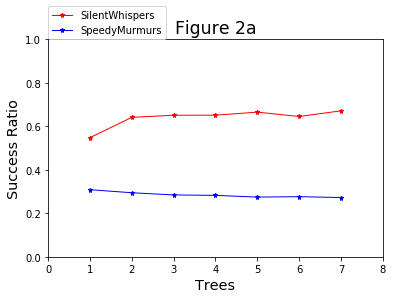

In [25]:
attempts = 1
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2a', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Trees', size='x-large')
matplotlib.pyplot.axis([0,8,0.0,1.0])

matplotlib.pyplot.plot(range(1,max_trees+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_trees+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 2b
The x-axis is the number of trees (or landmarks) used, and the y-axis is the number of hops a transaction took to reach its destination. Each point on the plot is the value of CREDIT_NETWORK_DELAY_AV in _singles.txt for the run with that many trees. All of these runs use 2 attempts.

Same simulations as 2a.


### Generate plots from data

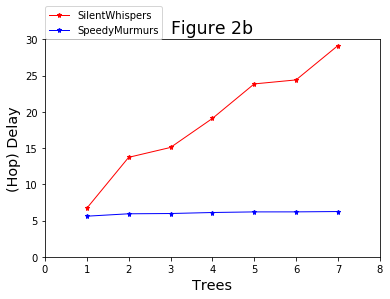

In [21]:
attempts = 1
key = 'CREDIT_NETWORK_DELAY_AV'
silentwhispers_data = extract_from_singles(silentwhispers, attempts, max_trees, key)
speedymurmurs_data = extract_from_singles(speedymurmurs, attempts, max_trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2b', size='xx-large')
matplotlib.pyplot.ylabel('(Hop) Delay', size='x-large')
matplotlib.pyplot.xlabel('Trees', size='x-large')
matplotlib.pyplot.axis([0,8,0,30])

matplotlib.pyplot.plot(range(1,max_trees+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_trees+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 2c
The x-axis is the number of times a failed transaction should be retried, and the y-axis is the ratio of successfully routed transaction to total transactions. Each point on the plot is the value of CREDIT_NETWORK_SUCCESS in \_singles.txt for the run with that many retries. All of these runs use 3 landmarks.

### Run simulations

In [ ]:
trees = 3
transaction_set = 0
for attempt in range(1, max_attempts+1):
    run_static(transaction_set, silentwhispers, attempt, trees)
    run_static(transaction_set, speedymurmurs, attempt, trees)
print('Done.')  
    

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Static 0 7 8 3


### Generate plots from data

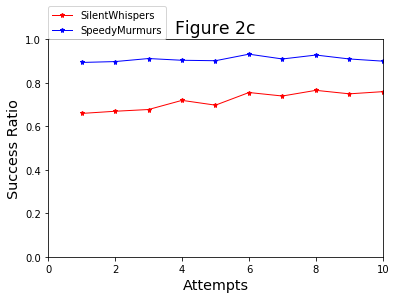

In [23]:
trees = 3
key = 'CREDIT_NETWORK_SUCCESS'
silentwhispers_data = extract_from_singles_attempts(silentwhispers, max_attempts, trees, key)
speedymurmurs_data = extract_from_singles_attempts(speedymurmurs, max_attempts, trees, key)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 2c', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Attempts', size='x-large')
matplotlib.pyplot.axis([0,10,0.0,1.0])

matplotlib.pyplot.plot(range(1,max_attempts+1), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1,max_attempts+1), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## Figure 3 Plots

## 3a
This is generated from the Ripple transaction data set, not from the simulator. The x-axis is the epoch number with epochs being of length 1000\*delta\_av, where delta\_av is calculated from the data set as the average time between two subsequent transactions. The y-axis is either the number of transactions or the number of transactions or link changes in that epoch. The number of transactions are determined by counting lines in the ripple transaction data set (for the epoch in question), and the link changes are determined by counting the number of lines in the newlinks data set (jan2013-newlinks-lcc-sorted-uniq-t\*.txt) for the epoch in question.

### Generate plots from data

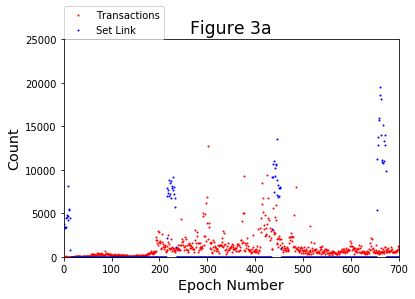

In [8]:
def get_epoch_length(transactions_file):
    transactions_list = []
    for i in range(1, 10):
        transactions_list = read_transactions_file(transactions_file.format(i), transactions_list)

    # sum the time between subsequent transctions
    sum_delta = 0
    for i in range(1, len(transactions_list)):
        sum_delta += transactions_list[i][0] - transactions_list[i - 1][0]
    delta_av = sum_delta/len(transactions_list)
    return (delta_av * 1000, transactions_list)

def read_link_changes_files(link_changes_file):
    link_changes_list = []
    for i in range(1, 10):
        link_changes_list = read_link_changes_file(link_changes_file.format(i), link_changes_list)
    return link_changes_list

def read_link_changes_file(link_changes_file, link_changes_list = []):
    with open(link_changes_file, 'r') as link_changes:
        count = 0
        for link_change in link_changes:
            lc = link_change.split(" ")
            # time, source, destination, amount
            link_changes_list.append((int(lc[0]), lc[1], lc[2], lc[3]))

        return link_changes_list

def calculate_events_per_epoch(epoch_length, events):
    cur_epoch = 1
    next_epoch_starts = epoch_length

    events_in_current_epoch = 0
    events_per_epoch = {}
    for event in events:
        if event[0] < next_epoch_starts:
            events_in_current_epoch += 1
        else:
            events_per_epoch[cur_epoch] = events_in_current_epoch
            next_epoch_starts += epoch_length
            cur_epoch += 1
            # should be 1 because it needs to include the current transaction
            events_in_current_epoch = 1
    return events_per_epoch

def read_transactions_file(transactions_file, transactions_list = []):
    with open(transactions_file, 'r') as transactions:
        count = 0
        for transaction in transactions:
            t = transaction.split(" ")
            if len(t) == 4:
                # time, amount, source, destination
                transactions_list.append((int(t[0]), t[1], t[2], t[3]))
            elif len(t) == 3:
                # time, amount, source, destination
                transactions_list.append((count, t[1], t[2], t[3]))
                count += 1

        return transactions_list

transactions_file = '../data/finalSets/dynamic/jan2013-trans-lcc-noself-uniq-{0}.txt'
link_changes_file = '../data/finalSets/dynamic/jan2013-newlinks-lcc-sorted-uniq-t{0}.txt'
epoch_length, transactions = get_epoch_length(transactions_file)
link_changes = read_link_changes_files(link_changes_file)


transactions_per_epoch = calculate_events_per_epoch(epoch_length, transactions)
link_changes_per_epoch = calculate_events_per_epoch(epoch_length, link_changes)
lc_per_epoch_list = dict_to_list(link_changes_per_epoch, 801)

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Figure 3a', size='xx-large')
matplotlib.pyplot.ylabel('Count', size='x-large')
matplotlib.pyplot.xlabel('Epoch Number', size='x-large')
matplotlib.pyplot.axis([0,700,0,25000])

matplotlib.pyplot.plot(range(1, 801), transactions_per_epoch.values(), 'ro', markersize=1, linewidth=1, label='Transactions')
matplotlib.pyplot.plot(range(1, 801), lc_per_epoch_list, 'bo', markersize=1, linewidth=1, label='Set Link')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)


## 3b
The x-axis is the epoch number with epochs calculated as above. The y-axis is the number of stabilization messages for that epoch. The number of stabilization messages can be determined from the cnet-stab.txt file which tracks stabilization messages per epoch. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [99]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
print('Done.')

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 7
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 7 8
Done.


### Generate plots from data

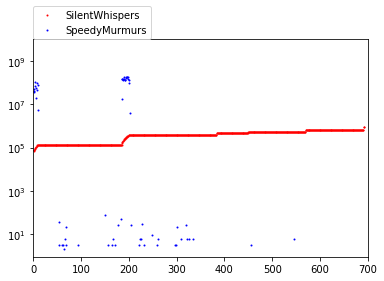

In [106]:
stab_file = '/cnet-stab.txt'

sw_stab_messages_list = []
sm_stab_messages_list = []
sw_stab_messages_dict = {}
sm_stab_messages_dict = {}
for step in range(0,9):
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + stab_file
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + stab_file

    # create dict of stab message values for both sw and sm
    new_dict_sw = convert_kv_file_to_dict(sw_file_path)
    new_dict_sm = convert_kv_file_to_dict(sm_file_path)

    sw_stab_messages_dict = merge_dicts(new_dict_sw, sw_stab_messages_dict)
    sm_stab_messages_dict = merge_dicts(new_dict_sm, sm_stab_messages_dict)

sw_stab_messages_list = dict_to_list(sw_stab_messages_dict, 801)
sm_stab_messages_list = dict_to_list(sm_stab_messages_dict, 801)

matplotlib.pyplot.yscale('log')
matplotlib.pyplot.axis([0,700,0,1e+10])
matplotlib.pyplot.plot(range(1, 801), sw_stab_messages_list, 'ro', markersize=1, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(1, 801), sm_stab_messages_list, 'bo', markersize=1, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)

## 3c
The x-axis is the epoch number with epochs calculated as above. The y-axis is the ratio of the success rate of SpeedyMurmurs or SilentWhispers to the success rate of Ford-Fulkerson. The lines in the plot are represented as a moving average over 50 epochs. All of these runs use 2 attempts and 3 landmarks.

### Run simulations

In [100]:
for step in range(0,9):
    run_dynamic(0, silentwhispers, 2, 3, step)
    run_dynamic(0, speedymurmurs, 2, 3, step)
    run_dynamic(0, maxflow, 2, 3, step)
print('Done.')

Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 1
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 2
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 3
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 4
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 5
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 6
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 7
Run exists. Skipping...
Run exists. Skipping...
Running: java -cp bin/ treeembedding.tests.Dynamic 0 10 8
Done.


### Generate plots from data

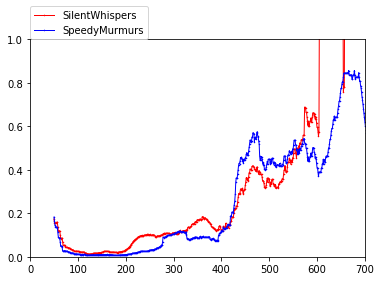

In [113]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

filename = '/cnet-succR.txt'

sw_succr_list = []
sm_succr_list = []
sw_succr_dict = {}
sm_succr_dict = {}
m_succr_dict = {}
for step in range(0, 9):
    m_file_path = get_dynamic_data_path(maxflow, 3, 2, step) + filename
    sw_file_path = get_dynamic_data_path(silentwhispers, 3, 2, step) + filename
    sm_file_path = get_dynamic_data_path(speedymurmurs, 3, 2, step) + filename

    # get succR for SW for each epoch
    sw_new_dict = convert_kv_file_to_dict(sw_file_path)
    sm_new_dict = convert_kv_file_to_dict(sm_file_path)
    m_new_dict = convert_kv_file_to_dict(m_file_path)
    
    sw_succr_dict = merge_dicts(sw_new_dict, sw_succr_dict)
    sm_succr_dict = merge_dicts(sm_new_dict, sm_succr_dict)
    m_succr_dict = merge_dicts(m_new_dict, m_succr_dict)

# update SW dict by dividing each value by the corresponding value in the M dict
for k,v in sw_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sw_succr_dict[k] = 1
        else:
            sw_succr_dict[k] = v/m_succr_dict[k]

# update SM dict by dividing each value by the corresponding value in the M dict
for k,v in sm_succr_dict.items():
    if k in m_succr_dict:
        if m_succr_dict[k] == 0:
            sm_succr_dict[k] = 1
        else:
            sm_succr_dict[k] = v/m_succr_dict[k]

sw_succr_list = dict_to_list(sw_succr_dict, 801)
sm_succr_list = dict_to_list(sm_succr_dict, 801)

matplotlib.pyplot.axis([0,700,0,1])
matplotlib.pyplot.plot(range(50, 801), running_mean(sw_succr_list, 50), 'r*-', markersize=1, linewidth=1, label='SilentWhispers')

matplotlib.pyplot.plot(range(50, 801), running_mean(sm_succr_list, 50), 'b*-', markersize=1, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,1), scatterpoints=10)



# Plot topology

## Define graph

In [9]:
def read_graph_file(graph_file):
    g = networkx.Graph()
    with open(graph_file, 'r') as graph_entries:
        count = 0
        for node in graph_entries:
            count += 1
            # skip meta data at beginning of file
            if count < 8:
                print(f"Skipping metadata, line: {count}")
                continue
            elif count > 15:
                print("Done")
                break
            
            node_id, connections_str = node.split(':')
            destinations = connections_str.split(';')
            print(f"node_id: {node_id}")
            for dest in destinations:
                #print(f'src: {node_id}; dest: {dest}')
                g.add_edge(node_id, dest)
            
            
    return g

topology_file = '../data/finalSets/static/ripple-lcc.graph'

G = read_graph_file(topology_file)

Skipping metadata, line: 1
Skipping metadata, line: 2
Skipping metadata, line: 3
Skipping metadata, line: 4
Skipping metadata, line: 5
Skipping metadata, line: 6
Skipping metadata, line: 7
node_id: 0
node_id: 1
node_id: 2
node_id: 3
node_id: 4
node_id: 5
node_id: 6
node_id: 7
Done


# Performance Under Attack

## Success ratio vs. Number of attackers

### Generate list of configurations

In [74]:
config_dict_list_srvna_sm = []
config_dict_list_srvna_sw = []
for data_set in range(0, 10):
    for alg in [speedymurmurs, silentwhispers]:
    # for alg in [silentwhispers]:
        for attackers in range(0, 30001, 5000):
        # for attackers in range(30000, 30001, 5000):
            config = f'''
data_set_name: tiny-{data_set}
base: ../tiny-data/finalSets/static
topology: ripple-lcc.graph
link_weights: ripple-lcc.graph_CREDIT_LINKS
transaction_set: sampleTr-{data_set}.txt
simulation_type: static
force_overwrite: false
routing_algorithm: "{alg}"
attempts: 1
trees: 3
attack_properties:
    attackers: {attackers}
    attacker_selection: "random"
    attack_type: drop_all
iterations: 1
'''
            if alg == speedymurmurs:
                config_dict_list_srvna_sm.append(parse_config(config))
            elif alg == silentwhispers:
                config_dict_list_srvna_sw.append(parse_config(config))



### Run experiment

In [118]:
%time do_experiments(config_dict_list_srvna_sm)
%time do_experiments(config_dict_list_srvna_sw)
print("Done.")

task 0; something: None
task 1; something: None
task 2; something: None
task 3; something: None
task 4; something: None
task 5; something: None
task 6; something: None
task 7; something: None
task 8; something: None
task 9; something: None
task 10; something: None
task 11; something: None
task 12; something: None
task 13; something: None
task 14; something: None
task 15; something: None
task 16; something: None
task 17; something: None
task 18; something: None
task 19; something: None
task 20; something: None
task 21; something: None
task 22; something: None
task 23; something: None
task 24; something: None
task 25; something: None
task 26; something: None
task 27; something: None
task 28; something: None
task 29; something: None
task 30; something: None
task 31; something: None
task 32; something: None
task 33; something: None
task 34; something: None
task 35; something: None
task 36; something: None
task 37; something: None
task 38; something: None
task 39; something: None
task 40; s

### Plot results

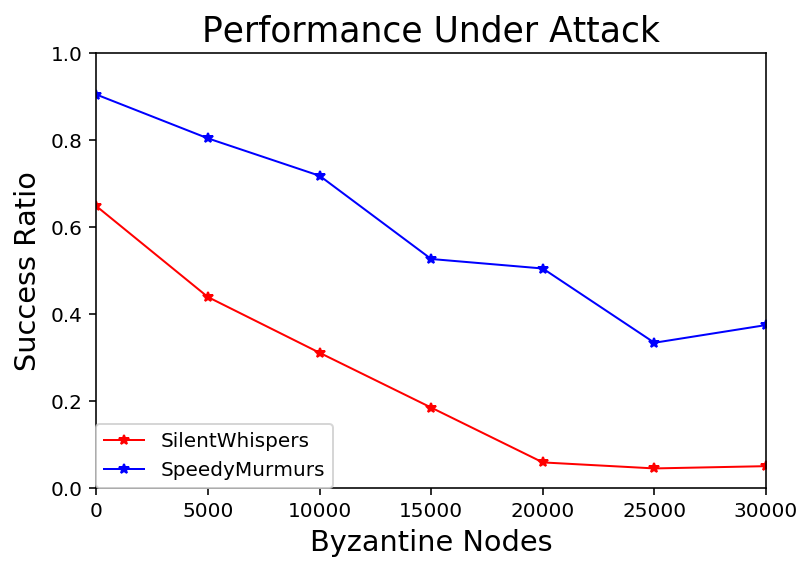

In [259]:
key = 'CREDIT_NETWORK_SUCCESS'

silentwhispers_data = extract_from_singles_config(config_dict_list_srvna_sw, key, "attack_properties", "attackers")
speedymurmurs_data = extract_from_singles_config(config_dict_list_srvna_sm, key, "attack_properties", "attackers")

matplotlib.pyplot.figure()
matplotlib.pyplot.title('Performance Under Attack', size='xx-large')
matplotlib.pyplot.ylabel('Success Ratio', size='x-large')
matplotlib.pyplot.xlabel('Byzantine Nodes', size='x-large')
matplotlib.pyplot.axis([0,30000,0.0,1.0])

%config InlineBackend.figure_format ='retina'
matplotlib.pyplot.plot(range(0,30001, 5000), silentwhispers_data, 'r*-', markersize=5, linewidth=1, label='SilentWhispers')
matplotlib.pyplot.plot(range(0,30001, 5000), speedymurmurs_data, 'b*-', markersize=5, linewidth=1, label='SpeedyMurmurs')
matplotlib.pyplot.legend(loc=(0,0), scatterpoints=10)

In [40]:
def test_func(x):
    import time
    time.sleep(x)
    t = time.time()
    return f"slept {x}; time: {t}"



In [41]:
#e = [(lambda: t(i)) for i in range(0, 4)]

ipyclient.ids
# v = ipyclient.load_balanced_view()
a = ipyclient[:].map_async(test_func, range(0,8))
for i,r in enumerate(a):
    print(f"task {i}; something: {r}")

task 0; something: slept 0; time: 1557501080.9879968
task 1; something: slept 1; time: 1557501081.990166


task 2; something: slept 2; time: 1557501082.9893508
task 3; something: slept 3; time: 1557501085.989772


task 4; something: slept 4; time: 1557501084.9919848
task 5; something: slept 5; time: 1557501089.995129


task 6; something: slept 6; time: 1557501086.988757
task 7; something: slept 7; time: 1557501093.993379
